# titanic の機械学習
#### 乗杉賢太

## 1．簡易的な機械学習による分析の準備と例

#### 欠損値が多いために、データーの解析とデータの前処理が非常に重要な役割を果たすので、それらの処理の結果を検証するのを楽にするために以下のような流れのmainの関数と検証用のクラスを作った
##### 決定木、ランダムフォレスト、勾配ブースティング、SVM,　MLP
##### グリッドサーチによる、最適なパラメーターの調整
##### パラーターの過剰適合回避のためのシャッフル分割交差検証を用いて精度を算出
#####  最も精度の高いモデルを判定する
##### examples

## 2. 特徴量エンコーディングと欠損値の補充

#### テキストデータを分類し、さらにその特徴を把握し処理を行う事で、１でランダムに行った分析よりも高い精度の結果を得る事ができた。0.82⇒0.86に上昇した
##### 名前とタイトル、タイトルからのageの平均値を取って補う
##### Cabinの統合
#####  乗り込んだ港別の分析

## 3. 欠損値について

## 4.自動特徴量選択

## 1. 簡易的な機械学習による分析の準備と例

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline


#なお検定houh方法はシャッフル分割交差検証を使う
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

shuffle_splite = ShuffleSplit(test_size=.5,train_size=.5,n_splits=10)
train = pd.DataFrame(pd.read_csv('train.csv'))
test = pd.DataFrame(pd.read_csv('test.csv'))



In [2]:
class ba(object):
    #前処理を検証する際に毎回機械学習のコードを書くのを簡略化する
    #決定木、ランダムフォレスト、勾配ブースティング、SVM,MLPのscoreを返す
    #scaled は　データの標準化を行ったデータによるSVM MLP
    #barは特徴量の重要性を棒グラフで表す
    def __init__(self,df,train=[0],test=0):
        self.df = df
        X_train,X_test,y_train,y_test= train_test_split(df.iloc[:,2:],df["Survived"],random_state=0)
        if len(train) != 1:
            X_train,X_test = train,test
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.importances = []
        #Minmax scaled
        min_on_training = self.X_train.min(axis=0)
        range_on_training = (self.X_train - min_on_training).max(axis=0)
        self.X_train_scaledM = (self.X_train - min_on_training)/range_on_training
        min_on_test = self.X_test.min(axis=0)
        range_on_test = (self.X_test - min_on_test).max(axis=0)
        self.X_test_scaledM = (self.X_test - min_on_test)/range_on_test
        #stadardization
        mean_on_train=self.X_train.mean(axis=0)
        std_on_train =self.X_train.std(axis=0)
        self.X_train_scaledS = (self.X_train - mean_on_train)/std_on_train
        self.X_test_scaledS = (self.X_test - mean_on_train)/std_on_train

    def bar(self):
        plt.clf()
        left = range(self.importances.shape[0])
        label = self.X_train.columns
        height= self.importances
        plt.figure(figsize=(12, 4), dpi=60)
        plt.bar(left,height, tick_label=label)
        return(self.importances)
    def tree(self,depth=20):
        tree = DecisionTreeClassifier(max_depth = depth,random_state = 0)
        tree.fit(self.X_train, self.y_train)
        score=cross_val_score(tree,self.X_train, self.y_train)
        score = np.mean(score)
        self.importances=tree.feature_importances_
        return(score,tree.score(self.X_test, self.y_test))

    def forest (self,depth = 30):
        forest = RandomForestClassifier(n_estimators = depth,random_state=0)
        forest.fit(self.X_train,self.y_train)
        score=cross_val_score(forest,self.X_train, self.y_train)
        score = np.mean(score)
        self.importances=forest.feature_importances_
        return(score,forest.score(self.X_test, self.y_test))

    def forest_ensemble(self,depth = 5):
        forest = GradientBoostingClassifier(max_depth = depth,random_state=0)
        forest.fit(self.X_train,self.y_train)
        score=cross_val_score(forest,self.X_train, self.y_train)
        score = np.mean(score)
        self.importances=forest.feature_importances_
        return(score,forest.score(self.X_test, self.y_test))

    def svc(self,gamma=0.001,C=100,method="S"):
        svc = SVC(gamma=gamma,C=C)
        svc.fit(self.X_train,self.y_train)
        score=cross_val_score(svc,self.X_train, self.y_train)
        score = np.mean(score)
        return(score,svc.score(self.X_test, self.y_test))

    def svc_scaled(self,gamma=0.001,C=100, method="S"):
        if method =="M":
            svc = SVC(gamma=gamma,C=C)
            svc.fit(self.X_train_scaledM,self.y_train)
            score=cross_val_score(svc,self.X_train_scaledM, self.y_train)
            score = np.mean(score)
            return(score,svc.score(self.X_test_scaledM, self.y_test))
        if method =="S":
            svc = SVC(gamma=gamma,C=C)
            svc.fit(self.X_train_scaledS,self.y_train)
            score=cross_val_score(svc,self.X_train_scaledS, self.y_train)
            score = np.mean(score)
            return(score,svc.score(self.X_test_scaledS, self.y_test))

    def mlp(self,h=10,method="S"):
        mlp = MLPClassifier(solver ='lbfgs', random_state=42,hidden_layer_sizes=[h,h])
        mlp.fit(self.X_train,self.y_train)
        score=cross_val_score(mlp,self.X_train, self.y_train)
        score = np.mean(score)
        return(score,mlp.score(self.X_test, self.y_test))
    
    def mlp_scaled(self,h=10,method="S"):
        if method =="M":
            mlp = MLPClassifier(solver ='lbfgs',random_state=42,hidden_layer_sizes=[h,h])
            mlp.fit(self.X_train_scaledM,self.y_train)
            score=cross_val_score(mlp,self.X_train_scaledM, self.y_train)
            score = np.mean(score)
            return(score,mlp.score(self.X_test_scaledM, self.y_test))     
        if method =="S":
            mlp = MLPClassifier(solver ='lbfgs',random_state=42,hidden_layer_sizes=[h,h])
            mlp.fit(self.X_train_scaledS,self.y_train)
            score=cross_val_score(mlp,self.X_train_scaledS, self.y_train)
            score = np.mean(score)
            return(score,mlp.score(self.X_test_scaledS, self.y_test))               

In [3]:
# forestとtreeに有用　ensembleにも適用できるが時間がかかってしまうかつ深くなっても精度が上がらない
def max_depth(mcl):
    c,d = 0,0
    for i in range(30):
        b = mcl(depth=i+1)[1]
        if c < b:
            c = b
            d = i+1
    return(c,d)

def max_depth_fe(mcl):
    c,d = 0,0
    for i in range(5):
        b = mcl(depth=i+1)[1]
        if c < b:
            c = b
            d = i+1
    return(c,d)

def max_svc(mcl,method="S"):
    best_score,c,g = 0,0,0
    for gamma in [0.001,0.01,0.1,1,10,100]:
        for C in [0.001,0.01,0.1,1,10,100]:
            score = mcl(gamma=gamma,C=C,method=method)[1]
            
            if score > best_score:
                best_score = score
                c,g = C,gamma 
    return(best_score,c,g)
def max_mlp_layer(mcl,method="S"):
    best_score,h= 0,0
    for n_hidden_nodes in [10,20,30,50,40,50,60,70,80,90,100]:
        score =mcl(h=n_hidden_nodes,method="S")[1]
        if score > best_score:
            best_score = score
            h= n_hidden_nodes
    return(best_score,h,h)
    

In [4]:
def main(mcl):
    a = []
    maxtree = max_depth(mcl.tree)
    print("maxtree","score,depth:",maxtree)    
    maxforest = max_depth(mcl.forest)
    print("maxforest","score,depth:",maxforest)    
    maxforest_e = max_depth_fe(mcl.forest_ensemble)
    print("maxforest_e","score,depth:",maxforest_e)
    maxsvc = max_svc(mcl.svc)
    print('maxsvc','score,C,gamma',maxsvc)
    mlp = mcl.mlp()
    print("mlp","score:",mlp[1])
    
#    a.extend([maxtree[0], maxforest[0], forest_e[1], maxsvc[0], maxsvc_s[0],mlp[1],mlp_s[1]])
    a.extend([maxtree[0], maxforest[0], maxforest_e[0], maxsvc[0], mlp[1]])
    b = [maxtree, maxforest, maxforest_e, maxsvc, mlp]
    max_score = max(a)
    for i in range(len(a)):
        if max_score == a[i]:
            print("best score:",b[i])

def main_scaled(mcl):
    maxsvc_s = max_svc(mcl.svc_scaled,method="S")
    print('maxsvc_s standardization','score,C,gamma',maxsvc_s)
    maxsvc_s = max_svc(mcl.svc_scaled,method="M")
    print('maxsvc_s minmax','score,C,gamma',maxsvc_s)
    mlp_s = max_mlp(mcl.mlp_scaled,method="S")
    print("maxmlp_s standardization","score:",mlp_s)
    mlp_s = max_mlp(mcl.mlp_scaled,method="M")
    print("maxmlp_s MinMax","score:",mlp_s)
    

### example 1
##### 名前　港名　キャビン　チケットを排除
##### 欠損値を削除
##### hot one encoding を使い特徴量を分類

In [5]:
df_train = train.drop(["Name","Embarked","Cabin","Ticket"],axis=1)
df_test = test.drop(["Name","Embarked","Cabin","Ticket"],axis=1)
df_train = pd.get_dummies(df_train)
df_train = df_train.dropna(axis=0,how='any')

maxtree score,depth: (0.8044692737430168, 4)
maxforest score,depth: (0.7932960893854749, 8)
maxforest_e score,depth: (0.8100558659217877, 2)
maxsvc score,C,gamma (0.776536312849162, 100, 0.001)
mlp score: 0.7988826815642458
best score: (0.8100558659217877, 2)


array([0.19, 0.29, 0.14, 0.06, 0.08, 0.05, 0.19])

<Figure size 432x288 with 0 Axes>

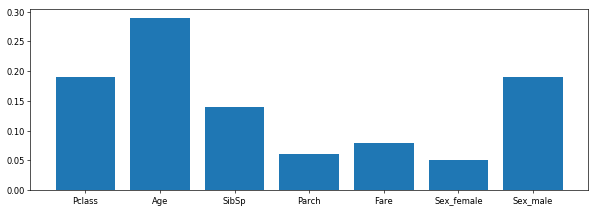

In [6]:
a = ba(df_train)
main(a)
a.forest_ensemble(depth=1)
a.bar()

### example 1-2
##### 名前　港名　キャビン　チケット parch　fareを削除
##### 欠損値を削除
##### hot one encoding を使い特徴量を分類

In [7]:
df_train = train.drop(["Name","Embarked","Cabin","Ticket","Parch","Fare"],axis=1)
df_test = test.drop(["Name","Embarked","Cabin","Ticket"],axis=1)
df_train = pd.get_dummies(df_train)
df_train = df_train.dropna(axis=0,how='any')

maxtree score,depth: (0.7877094972067039, 4)
maxforest score,depth: (0.7988826815642458, 29)
maxforest_e score,depth: (0.8044692737430168, 2)
maxsvc score,C,gamma (0.8100558659217877, 10, 0.1)
mlp score: 0.776536312849162
best score: (0.8100558659217877, 10, 0.1)


array([0.16060978, 0.35486514, 0.13092278, 0.        , 0.35360229])

<Figure size 432x288 with 0 Axes>

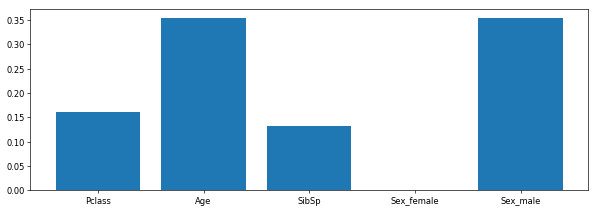

In [8]:
a = ba(df_train)
main(a)
a.tree()
a.bar()

In [9]:
max_svc(a.svc_scaled)

(0.8100558659217877, 100, 0.01)

### example 1-3
##### 名前　港名　キャビン　チケット parch fare Pclass SibSp を削除
##### 欠損値を削除
##### hot one encoding を使い特徴量を分類

In [10]:
df_train = train.drop(["Name","Embarked","Cabin","Ticket","Parch","Fare","Pclass","SibSp"],axis=1)
df_test = test.drop(["Name","Embarked","Cabin","Ticket"],axis=1)
df_train = pd.get_dummies(df_train)
df_train = df_train.dropna(axis=0,how='any')
df_train

,PassengerId,Survived,Age,Sex_female,Sex_male
0,1,0,22.0,0,1
1,2,1,38.0,1,0
2,3,1,26.0,1,0
3,4,1,35.0,1,0
4,5,0,35.0,0,1
6,7,0,54.0,0,1
7,8,0,2.0,0,1
8,9,1,27.0,1,0
9,10,1,14.0,1,0
10,11,1,4.0,1,0


In [11]:
a = ba(df_train)
main(a)

maxtree score,depth: (0.776536312849162, 1)
maxforest score,depth: (0.7541899441340782, 12)
maxforest_e score,depth: (0.7877094972067039, 1)
maxsvc score,C,gamma (0.7821229050279329, 100, 0.01)
mlp score: 0.776536312849162
best score: (0.7877094972067039, 1)


### example 2
##### NAN をmissingに変換 名前とチケット番号を消す
##### cabinデータをアルファベット事に分類
##### hot one encoding を使い特徴量を分類

In [12]:
df_train = train.drop(["Name","Ticket"],axis=1)
df_train=df_train.fillna('missing')
for i in range(df_train.shape[0]):
    df_train.set_value(index= i,col="Cabin",value = df_train.values[i][8][0])
df_train = pd.get_dummies(df_train)


/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [13]:
a= ba(df_train)
main(a)

maxtree score,depth: (0.8161434977578476, 8)
maxforest score,depth: (0.820627802690583, 20)
maxforest_e score,depth: (0.8071748878923767, 2)
maxsvc score,C,gamma (0.7937219730941704, 10, 0.1)
mlp score: 0.8071748878923767
best score: (0.820627802690583, 20)


array([0.07435521, 0.02957981, 0.02145749, 0.17875122, 0.32853516,
       0.        , 0.        , 0.00572047, 0.        , 0.01029442,
       0.00376055, 0.        , 0.00622092, 0.01522414, 0.01042546,
       0.00656177, 0.        , 0.        , 0.00246131, 0.00144331,
       0.        , 0.        , 0.00472101, 0.        , 0.        ,
       0.00429777, 0.        , 0.        , 0.01058687, 0.00521664,
       0.00491173, 0.00278513, 0.        , 0.        , 0.00166678,
       0.00154177, 0.        , 0.0007074 , 0.        , 0.00991692,
       0.01871911, 0.00816068, 0.01254464, 0.        , 0.00404322,
       0.00317569, 0.00455058, 0.01129792, 0.01129707, 0.        ,
       0.        , 0.00622435, 0.        , 0.00423846, 0.        ,
       0.        , 0.        , 0.01276582, 0.00144936, 0.00321539,
       0.        , 0.        , 0.00063151, 0.        , 0.00437695,
       0.00927772, 0.        , 0.        , 0.0095696 , 0.        ,
       0.00259017, 0.00192489, 0.        , 0.00582278, 0.     

<Figure size 432x288 with 0 Axes>

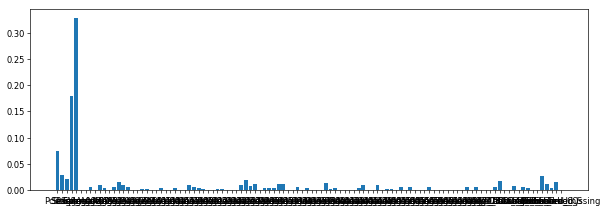

In [14]:
a.tree(depth = 20)
a.bar()

## 2. 特徴量エンコーディングと欠損値の補充

In [2]:
#ここからデータの考察と欠損値に関する考察を行う事によりより高い精度で計算を行う事が出来るようになると考えている

In [17]:
import re

###  名前の分析
#### 名前についているtitle を取り新たにtitleの行を作り格納する

In [15]:
train["Title"]=np.zeros(train.shape[0],dtype=np.str)

In [18]:
pattern = ["Mr.","Master.","Ms.","Miss.","Mrs.","Mme.","Countess.","Jonkheer.","Don.",
           "Rev.","Dr.","Col.","Major.","Capt.","Mlle."]
pattern_o = r"Mr.""|Master.""|Ms.""|Mrs.""|Rev.""|Dr.""|Don.""|Jonkheer.""|Miss.""|Countess.""|Mme.""|Col.""|Major.""|Mlle""|Capt."
repatter_o=re.compile(pattern_o)
title_c =[]
for h in range(len(pattern)):
    c =0
    repatter=re.compile(pattern[h])
    for i in range(train.shape[0]):
        matchOB = repatter.findall(train.Name[i])
        if matchOB == [pattern[h]]:
            train.set_value(index= i,col="Title",value = pattern[h])
            c += 1
        else:
            matchOB = repatter_o.findall(train.Name[i])
            if matchOB ==[]:
                train.set_value(index= i,col="Title",value = "other")
    title_c.append(c)

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


####  名前と生存率の関係性について
###### 他の特徴量についても同じような分析を行うため、関数として用意した

In [19]:
df_train = train.drop(["Name","Ticket"],axis=1)
def ave_suv(C,mlp):
    ave = []
    for h in range(len(C)):
        c0,c1 =0,0
        for i in range(df_train.shape[0]):
            if mlp[i] == C[h] and df_train.Survived[i]== 1: 
                c0 +=1
            if mlp[i] == C[h]:
                c1 += 1
        print(C[h],c1,c0/c1)
        ave.append(c0/c1)
    a0 = 0
    for i in range(df_train.shape[0]):
        if df_train.Survived[i] == 1: 
            a0 +=1
    print("Average",a0/df_train.shape[0])
    left = range(len(C))
    label = C
    average = ave
    plt.figure(figsize=(12, 4), dpi=60)
    plt.bar(left,height=ave, tick_label=label)
    return ()

Mr. 514 0.15369649805447472
Master. 40 0.575
Ms. 1 1.0
Miss. 182 0.6978021978021978
Mrs. 125 0.792
Mme. 1 1.0
Countess. 1 1.0
Jonkheer. 1 0.0
Don. 1 0.0
Rev. 6 0.0
Dr. 7 0.42857142857142855
Col. 2 0.5
Major. 2 0.5
Capt. 1 0.0
Mlle. 2 1.0
Average 0.3838383838383838


()

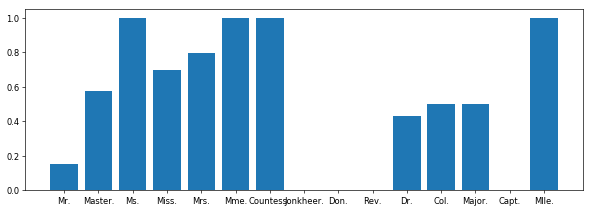

In [20]:
ave_suv(pattern,train.Title)

#####  聖職者ＤＯＮやＲＥＶの死亡率は100％である事、若く、男性の方が死亡率が高い事が特徴的

In [21]:
df_train= train.drop(["Name","SibSp","Embarked","Ticket","Parch","Cabin"],axis=1)
df_train = pd.get_dummies(df_train)
df_train = df_train.dropna(axis=0,how='any')

maxtree score,depth: (0.8268156424581006, 4)
maxforest score,depth: (0.7821229050279329, 8)
maxforest_e score,depth: (0.8156424581005587, 5)
maxsvc score,C,gamma (0.7877094972067039, 100, 0.001)
mlp score: 0.7932960893854749
best score: (0.8268156424581006, 4)


array([0.10489396, 0.22625124, 0.28025541, 0.        , 0.01252192,
       0.00598086, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00531632, 0.01573093,
       0.        , 0.        , 0.31736945, 0.        , 0.        ,
       0.03167991])

<Figure size 432x288 with 0 Axes>

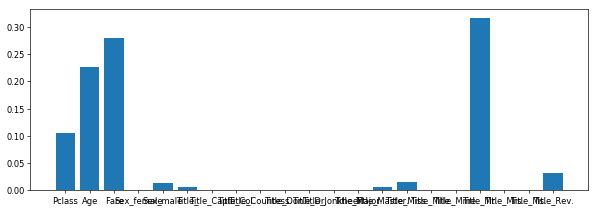

In [22]:
a= ba(df_train)
main(a)
a.tree()
a.bar()

#### 名前（title）と年齢に関して

In [23]:
df_train= train.drop(["Name","Ticket"],axis=1)
df_train=df_train.fillna("missing")
#あとで同じような作業をする際に一連の作業を関数に書き換えている
age_ave=[]

for h in range(len(pattern)):
    c = 0
    c1=0
    for i in range(df_train.shape[0]):
        if df_train.Age[i] !="missing":
            if df_train.Title[i] == pattern[h]:
                c += df_train.Age[i]
                c1 += 1
    ave = c/c1
    age_ave.append(ave)
print(age_ave,pattern)

[32.312658227848104, 4.574166666666667, 28.0, 21.773972602739725, 35.898148148148145, 24.0, 33.0, 38.0, 40.0, 43.166666666666664, 42.0, 58.0, 48.5, 70.0, 24.0] ['Mr.', 'Master.', 'Ms.', 'Miss.', 'Mrs.', 'Mme.', 'Countess.', 'Jonkheer.', 'Don.', 'Rev.', 'Dr.', 'Col.', 'Major.', 'Capt.', 'Mlle.']


In [24]:
#平均値で欠損値を補う事は非常に安易な方法であるが、とりあえず試してみる
for h in range(len(pattern)):
    for i in range(df_train.shape[0]):
        if df_train.Age[i] =="missing":
            if df_train.Title[i] == pattern[h]:
                df_train.set_value(index= i,col="Age",value = age_ave[h])

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


##### 職種が似ているもの性質が似ていると考えられるものをまとめる
##### 聖職者関係Rev,Don ⇒　Rev
##### 貴族関係 Countess Jonkheer ⇒ Countess
##### 軍関係者 Col,Major,Cap ⇒　Officer
##### 若い女性　Ms Miss MLLE ⇒ Ms

In [25]:
for i in range(df_train.shape[0]):
    if df_train.Title[i] == "Don.":
        df_train.set_value(index= i,col="Title",value = "Rev.")
    if df_train.Title[i] == "Jonkheer.":
        df_train.set_value(index= i,col="Title",value = "Countess.")
    if df_train.Title[i] == "Major." or df_train.Title[i] == "Col." or df_train.Title[i] == "Capt.":
        df_train.set_value(index= i,col="Title",value = "Officer.")
    if df_train.Title[i] == "Mlle." or df_train.Title[i] == "Miss.":
        df_train.set_value(index= i,col="Title",value = "Ms.")
df_train_agefilled = df_train
df_train= df_train.drop(["Embarked","Cabin"],axis=1)

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [26]:
df_train = pd.get_dummies(df_train)
a = ba(df_train)
main(a)

maxtree score,depth: (0.8116591928251121, 3)
maxforest score,depth: (0.8251121076233184, 8)
maxforest_e score,depth: (0.8116591928251121, 2)
maxsvc score,C,gamma (0.7982062780269058, 100, 0.001)
mlp score: 0.7982062780269058
best score: (0.8251121076233184, 8)


##### どのモデルでもほとんど安定した結果を生み出せている

array([5.41741253e-02, 5.06559557e-02, 3.77214005e-02, 2.19689666e-01,
       1.04506813e-01, 4.03528687e-02, 0.00000000e+00, 6.20907443e-04,
       1.59289923e-03, 7.93498236e-04, 4.18135957e-04, 5.70928082e-03,
       7.38619879e-03, 4.20281413e-03, 4.31171928e-03, 4.50329586e-04,
       3.26356173e-03, 2.50142632e-04, 0.00000000e+00, 1.23859202e-03,
       4.32990279e-03, 5.35919439e-04, 7.59589039e-04, 1.75170458e-03,
       8.38368014e-06, 9.77653024e-05, 3.18316520e-03, 1.57479661e-03,
       2.76921592e-03, 5.58546704e-03, 6.93240453e-03, 5.94133756e-03,
       5.12069288e-03, 5.42229840e-05, 2.83633514e-03, 8.87925261e-03,
       5.92086150e-03, 2.50772661e-03, 4.46105444e-05, 8.89305000e-03,
       0.00000000e+00, 1.40943709e-02, 1.07697027e-02, 1.42491452e-02,
       6.46877623e-03, 4.92888176e-04, 6.63027272e-03, 3.93648185e-03,
       2.46611954e-03, 9.14219328e-03, 1.32974889e-02, 1.71273861e-02,
       8.83350083e-05, 8.65818421e-04, 1.94695701e-03, 3.43551394e-05,
      

<Figure size 432x288 with 0 Axes>

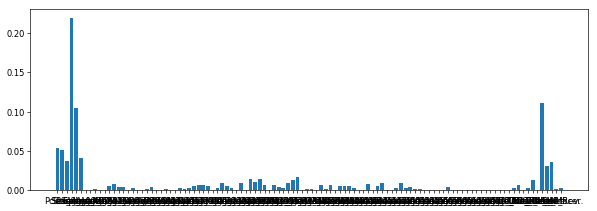

In [27]:
a.forest(depth=8)
a.bar()

### Cabinの分析

In [28]:
df_train = train.drop(["Name","Ticket"],axis=1)
df_train=df_train.fillna('missing')
df_train
for i in range(df_train.shape[0]):
    df_train.set_value(index= i,col="Cabin",value = df_train.Cabin[i][0])

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


A 15 0.4666666666666667
B 47 0.7446808510638298
C 59 0.5932203389830508
D 33 0.7575757575757576
E 32 0.75
F 13 0.6153846153846154
G 4 0.5
Average 0.3838383838383838


()

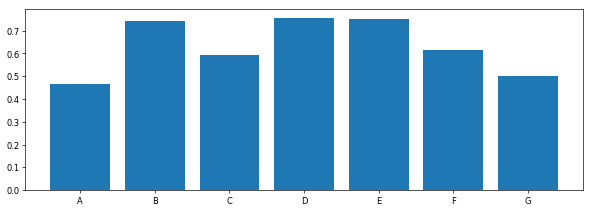

In [29]:
list_cabin = ["A","B","C","D","E","F","G"]
ave_suv(list_cabin,df_train.Cabin)

##### 全体の生存率としてCabinのデーターがある場合うはその生存率は高いと言える
##### サンプル数が少ないため　生存率のグループ順に分けても面白いかもしれないＢＤＥ/ＣＦ/A,G

In [30]:
df_train=df_train_agefilled

In [31]:
df_train=df_train.fillna('missing')
for i in range(df_train.shape[0]):
    df_train.set_value(index= i,col="Cabin",value = df_train.Cabin[i][0])
df_train = pd.get_dummies(df_train)

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
a0 = ba(df_train)
main(a0)

maxtree score,depth: (0.8295964125560538, 7)
maxforest score,depth: (0.8475336322869955, 25)
maxforest_e score,depth: (0.8385650224215246, 3)
maxsvc score,C,gamma (0.7982062780269058, 100, 0.001)
mlp score: 0.8116591928251121
best score: (0.8475336322869955, 25)


#### 精度が大きく飛躍している、過剰適合の少なからず可能性もある（シャッフル分割交差検証）
##### グループ分けしたものを使ってみる

In [33]:
df_train=df_train_agefilled
def cabin_conv(df_train):
    df_train=df_train.fillna('missing')
    for i in range(df_train.shape[0]):
        df_train.set_value(index= i,col="Cabin",value = df_train.Cabin[i][0])
    for i in range(df_train.shape[0]):
        if df_train.Cabin[i] == "B" or df_train.Cabin[i] == "D" or df_train.Cabin[i] == "E":
            df_train.set_value(index= i,col="Cabin",value = "High")
        if df_train.Cabin[i] == "C" or df_train.Cabin[i] == "F":
            df_train.set_value(index= i,col="Cabin",value = "Intermidiate")
        if df_train.Cabin[i] == "A" or df_train.Cabin[i] == "G":
            df_train.set_value(index= i,col="Cabin",value = "Low")
    return(df_train)
df_train = cabin_conv(df_train)
df_train = pd.get_dummies(df_train)
a0 = ba(df_train)
main(a0)


/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


maxtree score,depth: (0.8295964125560538, 5)
maxforest score,depth: (0.8430493273542601, 24)
maxforest_e score,depth: (0.8609865470852018, 3)
maxsvc score,C,gamma (0.7982062780269058, 100, 0.001)
mlp score: 0.820627802690583
best score: (0.8609865470852018, 3)


## さらに精度が上昇している！！！
#### 過剰適合の可能性を否定できない
##### 折角なので、スケールを調整したもので再度ニュートラルネットワークを行ってみたい

In [34]:
# かなり長い計算時間が必要になってしまうので注意
max_mlp_layer(a0.mlp)

(0.83856502242152464, 70, 70)

In [35]:
max_mlp_layer(a0.mlp_scaled)

(0.80717488789237668, 10, 10)

#### 残念ながら精度は上がらなかった

#### Ticket とＣａｂｉｎの関係性について

### Embarkedの分析

S 644 0.33695652173913043
C 168 0.5535714285714286
Q 77 0.38961038961038963
Average 0.3838383838383838


()

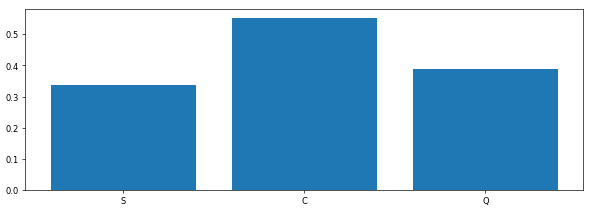

In [36]:
list_em=["S","C","Q"]
ave_suv(list_em,train.Embarked)

##### 若干の偏りがある、特にＣに関しては0.1異常高いのが気になる⇒統計的優位性を検証するべき
##### まず生死との相関関係について見てみる

In [37]:
df_train=pd.DataFrame([train.Survived,train.Embarked]).T
df_train = pd.get_dummies(df_train)

In [38]:
print(np.corrcoef(df_train.Survived_1,df_train.Embarked_C))
print(np.corrcoef(df_train.Survived_1,df_train.Embarked_S))
print(np.corrcoef(df_train.Survived_1,df_train.Embarked_Q))

[[ 1.          0.16824043]
 [ 0.16824043  1.        ]]
[[ 1.         -0.15566027]
 [-0.15566027  1.        ]]
[[ 1.          0.00365038]
 [ 0.00365038  1.        ]]


##### 非常に弱い相関関係のものしかないため、この特徴量では分類しにくい事が分かる
#### Cabinと生死の相関についても考えて見る

In [39]:
df_train=df_train_agefilled
df_train = cabin_conv(df_train)
df_train = pd.get_dummies(df_train)

print(np.corrcoef(df_train.Survived,df_train.Cabin_High))
print(np.corrcoef(df_train.Survived,df_train.Cabin_Intermidiate))
print(np.corrcoef(df_train.Survived,df_train.Cabin_Low))
print(np.corrcoef(df_train.Survived,df_train.Cabin_m))

[[ 1.          0.28549045]
 [ 0.28549045  1.        ]]
[[ 1.          0.13009611]
 [ 0.13009611  1.        ]]
[[ 1.          0.02727062]
 [ 0.02727062  1.        ]]
[[ 1.         -0.31691152]
 [-0.31691152  1.        ]]


#### データーがない方が死ぬ確率が高く　一方で、Ｈｉｇｈでは相対的に高めの値が出ている

## 3.欠損値に関する考察

In [40]:
missing = train.copy()
missing = missing.apply(pd.isnull, axis=0)
missing['count'] = 1
missing.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'count'],
      dtype='object')

In [41]:
missing.groupby([ 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']).sum()

PassengerId  Survived  Pclass  \
Age   SibSp Parch Ticket Fare  Cabin Embarked                                  
False False False False  False False False           False     False   False   
                                     True            False     False   False   
                               True  False           False     False   False   
True  False False False  False False False           False     False   False   
                               True  False           False     False   False   

                                                Name    Sex  Title  count  
Age   SibSp Parch Ticket Fare  Cabin Embarked                              
False False False False  False False False     False  False  False    183  
                                     True      False  False  False      2  
                               True  False     False  False  False    529  
True  False False False  False False False     False  False  False     19  
                               True  False     False  False  False    158

In [42]:
missing.pivot_table(index='Age', columns='Cabin', values='count', aggfunc='sum')

Cabin,False,True
Age,,
False,185,529
True,19,158


##### 基本的にＣａｂｉｎが分かっていなければＡＧＥも分かっていない事が多い
##### Ｃａｂｉｎを分類する事で比較的精度が上昇した事から出来れば、Ｃａｂｉｎを落としたくないため、ＡＧＥの穴埋めに力を入れなくてはいけない

#### Age を平均値ではなく中央値,最頻値で補ってみる

In [43]:
df_train_n= train.drop(["Name","Ticket"],axis=1)
df_train_n=df_train_n.fillna("missing")

def fillnanage(df_train,method):
    c=[]
    for h in range(len(pattern)):
        c.append([])
        for i in range(df_train.shape[0]):
            if df_train.Age[i] !="missing":
                if df_train.Title[i] == pattern[h]:
                    c[h].append(df_train.Age[i])
    for h in range(len(pattern)):
        for i in range(df_train.shape[0]):
            if df_train.Age[i] =="missing":
                if df_train.Title[i] == pattern[h]:
                    df_train.set_value(index= i,col="Age",value = method(c[h]))
    for i in range(df_train.shape[0]):
        df_train.set_value(index= i,col="Cabin",value = df_train.Cabin[i][0])
    df_train = cabin_conv(df_train)
    df_train = pd.get_dummies(df_train)
    a0 = ba(df_train)
    main(a0)

    
print("mean")
fillnanage(df_train_n,np.mean)
df_train_n= train.drop(["Name","Ticket"],axis=1)
df_train_n=df_train_n.fillna("missing")
print("median")
fillnanage(df_train_n,np.median)

df_train_n= train.drop(["Name","Ticket"],axis=1)
df_train_n=df_train_n.fillna("missing")
from collections import Counter
def fillnanagecount(df_train):
    c=[]
    for h in range(len(pattern)):
        c.append([])
        for i in range(df_train.shape[0]):
            if df_train.Age[i] !="missing":
                if df_train.Title[i] == pattern[h]:
                    c[h].append(df_train.Age[i])
    for h in range(len(pattern)):
        for i in range(df_train.shape[0]):
            if df_train.Age[i] =="missing":
                if df_train.Title[i] == pattern[h]:
                    mode = Counter(c[h])
                    value = mode.most_common(1) 
                    df_train.set_value(index= i,col="Age",value = value[0][0])
    for i in range(df_train.shape[0]):
        df_train.set_value(index= i,col="Cabin",value = df_train.Cabin[i][0])
    df_train = cabin_conv(df_train)
    df_train = pd.get_dummies(df_train)
    a0 = ba(df_train)
    main(a0)
print("most frequent")
fillnanagecount(df_train_n)

mean
maxtree score,depth: (0.82959641255605376, 7)
maxforest score,depth: (0.84753363228699552, 20)
maxforest_e score,depth: (0.86547085201793716, 3)
maxsvc score,C,gamma (0.7982062780269058, 100, 0.001)
mlp score: 0.825112107623
best score: (0.86547085201793716, 3)
median
maxtree score,depth: (0.83856502242152464, 7)
maxforest score,depth: (0.86098654708520184, 28)
maxforest_e score,depth: (0.86098654708520184, 3)
maxsvc score,C,gamma (0.7982062780269058, 100, 0.001)
mlp score: 0.825112107623
best score: (0.86098654708520184, 28)
best score: (0.86098654708520184, 3)
most frequent
maxtree score,depth: (0.82959641255605376, 8)
maxforest score,depth: (0.86547085201793716, 20)
maxforest_e score,depth: (0.8565022421524664, 3)
maxsvc score,C,gamma (0.78923766816143492, 100, 0.001)
mlp score: 0.793721973094
best score: (0.86547085201793716, 20)


#### 全体的には、中央値の場合が最も安定した結果を返している
## 今回の検証の中で最も高い値0.865
### ここからはどの特徴量を用いどれを用いないのかについて検討する必要性がある

## 4.自動特徴量選択
##### 下準備としてこれまで作ってきたデータを統合したものを作る

In [34]:
df_train =  train.drop(["Name","Ticket"],axis=1)
df_train["Title_o"]=np.zeros(train.shape[0],dtype=np.str)
df_train["Cabin_group"]=np.zeros(train.shape[0],dtype=np.str)
df_train["Age_ave"]=np.zeros(train.shape[0],dtype=np.str)
df_train["Age_med"]=np.zeros(train.shape[0],dtype=np.str)
df_train=df_train.fillna("missing")
for i in range(df_train.shape[0]):
    df_train.set_value(index= i,col="Cabin",value = df_train.Cabin[i][0])
for i in range(df_train.shape[0]):
    df_train.set_value(index= i,col="Title_o",value = df_train.Title[i] )
    if df_train.Title[i] == "Don.":
        df_train.set_value(index= i,col="Title_o",value = "Rev.")
    if df_train.Title[i] == "Jonkheer.":
        df_train.set_value(index= i,col="Title_o",value = "Countess.")
    if df_train.Title[i] == "Major." or df_train.Title[i] == "Col." or df_train.Title[i] == "Capt.":
        df_train.set_value(index= i,col="Title_o",value = "Officer.")
    if df_train.Title[i] == "Mlle." or df_train.Title[i] == "Miss.":
        df_train.set_value(index= i,col="Title_o",value = "Ms.")
def cabin_conv(df_train):
    for i in range(df_train.shape[0]):
        if df_train.Cabin[i] == "B" or df_train.Cabin[i] == "D" or df_train.Cabin[i] == "E":
            df_train.set_value(index= i,col="Cabin_group",value = "High")
        if df_train.Cabin[i] == "C" or df_train.Cabin[i] == "F":
            df_train.set_value(index= i,col="Cabin_group",value = "Intermidiate")
        if df_train.Cabin[i] == "A" or df_train.Cabin[i] == "G":
            df_train.set_value(index= i,col="Cabin_group",value = "Low")
        else:
            df_train.set_value(index= i,col="Cabin_group",value = "missing")
    return(df_train)
df_train = cabin_conv(df_train)
def fillnanage_ave(df_train):
    c=[]
    for h in range(len(pattern)):
        c.append([])
        for i in range(df_train.shape[0]):
            if df_train.Age[i] !="missing":
                if df_train.Title[i] == pattern[h]:
                    c[h].append(df_train.Age[i])
    for h in range(len(pattern)):
        for i in range(df_train.shape[0]):
            if df_train.Age[i] =="missing":
                if df_train.Title[i] == pattern[h]:
                    df_train.set_value(index= i,col="Age_ave",value = int(np.mean(c[h])))
            else:
                df_train.set_value(index= i,col="Age_ave",value =int(df_train.Age[i]))
    return(df_train)
df_train = fillnanage_ave(df_train)
def fillnanage_med(df_train):
    c=[]
    for h in range(len(pattern)):
        c.append([])
        for i in range(df_train.shape[0]):
            df_train.set_value(index= i,col="Age_med",value = df_train.Age[i])
            if df_train.Age[i] !="missing":
                if df_train.Title[i] == pattern[h]:
                    c[h].append(df_train.Age[i])
    for h in range(len(pattern)):
        for i in range(df_train.shape[0]):
            if df_train.Age[i] =="missing":
                if df_train.Title[i] == pattern[h]:
                    df_train.set_value(index= i,col="Age_med",value = np.median(c[h]))
    return(df_train)
df_train_n = fillnanage_med(df_train)

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and wi

In [35]:
df_train = pd.get_dummies(df_train_n)
from sklearn.feature_selection import SelectFromModel

### モデルデータベース特徴量選択

In [36]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=42),threshold="median")
X_train,X_test,y_train,y_test= train_test_split(df_train.iloc[:,2:],df_train["Survived"],random_state=0)
select.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold='median')

In [37]:
X_train_l1= select.transform(X_train)
X_test_l1= select.transform(X_test)
print("X_train.shape:{}".format(X_train.shape))
print("X_train_l1:{}".format(X_train_l1.shape))

X_train.shape:(668, 297)
X_train_l1:(668, 149)


##### 227中668選ばれた

In [38]:
a = ba(df_train,train=X_train_l1,test=X_test_l1)
main(a)

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


maxtree score,depth: (0.8071748878923767, 4)
maxforest score,depth: (0.8251121076233184, 9)
maxforest_e score,depth: (0.8116591928251121, 5)
maxsvc score,C,gamma (0.8116591928251121, 10, 0.1)
mlp score: 0.7937219730941704
best score: (0.8251121076233184, 9)


#### 無駄なものを入れ過ぎたのでそぎ落とす

In [39]:
#df_train =  df_train.drop(["Title_o","Age_med","Age"],axis=1)
df_train =  df_train_n.drop(["Title","Age_med","Age"],axis=1)
cols = list(df_train.columns.values)
df_train = df_train[['PassengerId','Survived','Age_ave','Pclass','Sex',
                     'SibSp','Parch','Fare','Cabin','Embarked',
                     'Title_o','Cabin_group']]
def selectioncheck(df_train):
    df_train = pd.concat([df_train.iloc[:,:3],pd.get_dummies(df_train.iloc[:,3:])],axis=1)
    select = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=42),threshold="median")
    X_train,X_test,y_train,y_test= train_test_split(df_train.iloc[:,2:],df_train["Survived"],random_state=0)
    select.fit(X_train,y_train)
    X_train_l1= select.transform(X_train)
    X_test_l1= select.transform(X_test)
    print("X_train.shape:{}".format(X_train.shape))
    print("X_train_l1:{}".format(X_train_l1.shape))
    a = ba(df_train,train=X_train_l1,test=X_test_l1)
    main(a)
selectioncheck(df_train)

X_train.shape:(668, 32)
X_train_l1:(668, 16)
maxtree score,depth: (0.820627802690583, 4)
maxforest score,depth: (0.8385650224215246, 14)
maxforest_e score,depth: (0.8430493273542601, 5)
maxsvc score,C,gamma (0.8026905829596412, 100, 0.001)
mlp score: 0.8251121076233184
best score: (0.8430493273542601, 5)


In [40]:
df_train =  df_train_n.drop(["Title","Age_med","Age","Cabin"],axis=1)
selectioncheck(df_train)

X_train.shape:(668, 93)
X_train_l1:(668, 47)


/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


maxtree score,depth: (0.8116591928251121, 5)
maxforest score,depth: (0.8475336322869955, 4)
maxforest_e score,depth: (0.8161434977578476, 5)
maxsvc score,C,gamma (0.820627802690583, 1, 1)
mlp score: 0.7892376681614349
best score: (0.8475336322869955, 4)


In [41]:
df_train =  df_train_n.drop(["Title_o","Age_med","Age","Cabin"],axis=1)
selectioncheck(df_train)

X_train.shape:(668, 99)
X_train_l1:(668, 50)


/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


maxtree score,depth: (0.8161434977578476, 5)
maxforest score,depth: (0.8295964125560538, 16)
maxforest_e score,depth: (0.8116591928251121, 3)
maxsvc score,C,gamma (0.8251121076233184, 100, 0.1)
mlp score: 0.8071748878923767
best score: (0.8295964125560538, 16)


### ここでこれまで一番高い値を出していたデータを使ってみる

In [42]:
df_train=df_train_agefilled
df_train = cabin_conv(df_train)
df_train = pd.get_dummies(df_train)
selectioncheck(df_train)

/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


X_train.shape:(668, 261)
X_train_l1:(668, 131)


/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/Ken/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


maxtree score,depth: (0.8116591928251121, 3)
maxforest score,depth: (0.8340807174887892, 24)
maxforest_e score,depth: (0.8295964125560538, 5)
maxsvc score,C,gamma (0.8161434977578476, 10, 0.1)
mlp score: 0.7892376681614349
best score: (0.8340807174887892, 24)


####  特徴量選択の際にデータの数がそぎ落とされてしまい（891→668）精度が落ちていると考えらるが過剰適合を回避しているという面では優位なのかもしれない

## 最も精度の高いモデル

In [44]:
print("test score:",a0.forest_ensemble(depth=3)[1])

test score: 0.8609865470852018
